# <center> Abalone's Age -- Regression</center>

---

Link to data: https://www.kaggle.com/datasets/nimapourmoradi/abalones-age/data



In [29]:
import inflection
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pymc as pm


from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [17]:
abalone_df = pd.read_csv("abalone.csv")
abalone_df.columns = ["sex", "length", "diameter", "height", "whole_weight_shucked_weight",
                        "viscera_weight", "shell_weight", "rings", "age"]

abalone_df.head(5)

,sex,length,diameter,height,whole_weight_shucked_weight,viscera_weight,shell_weight,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [19]:
X = abalone_df.drop(columns=["sex", "age"])
y = abalone_df["age"]

#### split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

X_train

##### for bayesian
abalone_bayes = abalone_df.drop(columns="sex")

------
## Linear Regression

----

In [4]:
lin_mdl = LinearRegression().fit(X_train, y_train)

y_pred = lin_mdl.predict(X_test)

lin_mdl.score(X_test, y_test)

0.5458509885456793

In [35]:
lr_coeff = pd.DataFrame(list(zip(X_train.columns, lin_mdl.coef_)), columns=["features", "coeff"])

In [5]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace( go.Scatter(x=y_test, y=y_pred, mode="markers"), row=1, col=1)

fig.show()

In [23]:
def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression 
    model on supplied data.

    Parameters
    ----------
    df: `pd.DataFrame`
        DataFrame containing the data
    iterations: `int`
        Number of iterations to carry out MCMC for
    """
    # Create the glm using the Bambi model syntax
    model = bmb.Model("age ~ length + diameter + height + whole_weight_shucked_weight + \
                      viscera_weight + shell_weight + rings", df)

    # Fit the model using a NUTS (No-U-Turn Sampler) 
    trace = model.fit(
        draws=5000,
        tune=500,
        discard_tuned_samples=True,
        chains=1, 
        progressbar=True)
    return trace

In [20]:
abalone_bayes

,length,diameter,height,whole_weight_shucked_weight,viscera_weight,shell_weight,rings,age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [24]:
test = glm_mcmc_inference(abalone_bayes)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [age_sigma, Intercept, length, diameter, height, whole_weight_shucked_weight, viscera_weight, shell_weight, rings]


Sampling 1 chain for 500 tune and 5_000 draw iterations (500 + 5_000 draws total) took 101 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


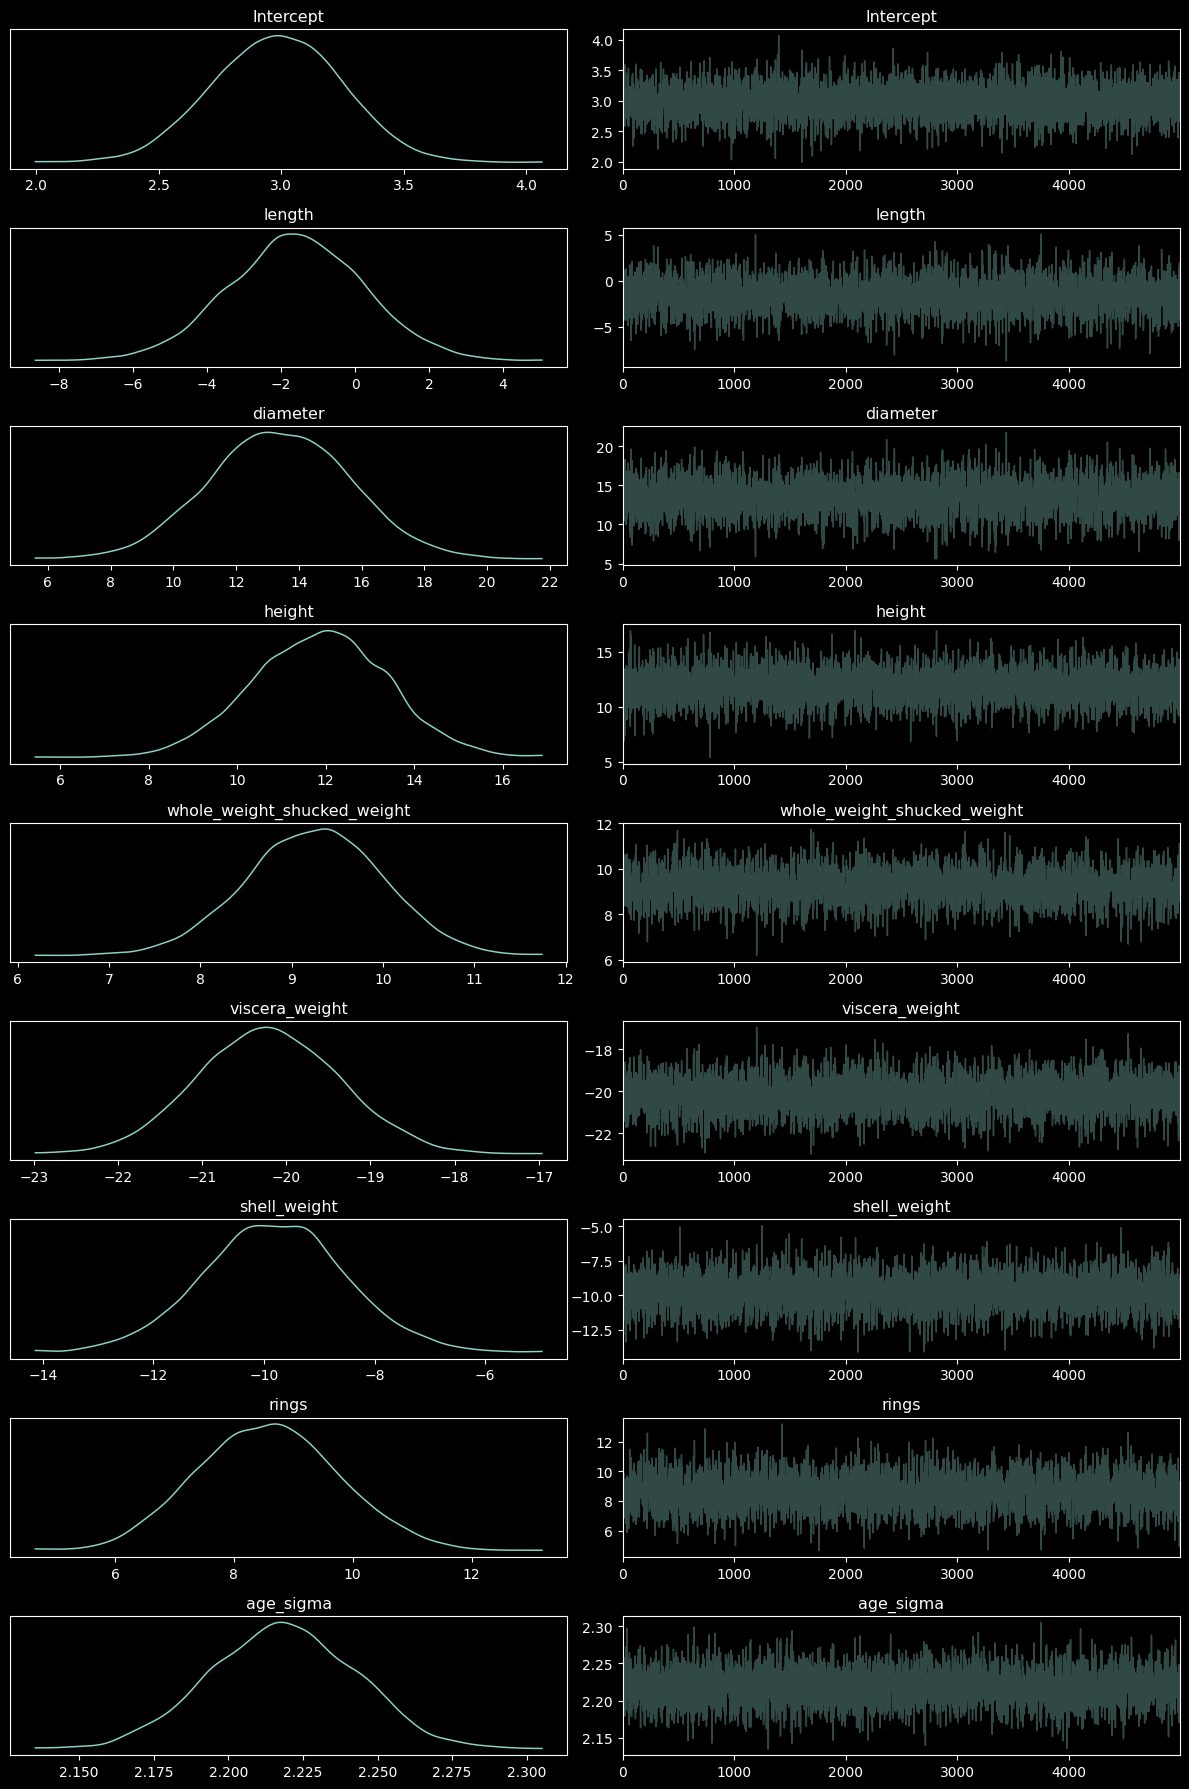

In [30]:
pm.plot_trace(test)
plt.tight_layout()
plt.show()

In [36]:
lr_coeff

,features,coeff
0,length,-2.232229
1,diameter,14.469171
2,height,11.049217
3,whole_weight_shucked_weight,9.180711
4,viscera_weight,-19.663288
5,shell_weight,-10.262355
6,rings,8.335987


In [37]:
test.posterior

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [38]:
test.posterior.rings.to_numpy()

array([[8.94763848, 9.05253788, 9.27897752, ..., 7.04454722, 9.3094611 ,
        9.24089181]])